# FormationML Equinor Volve

**Data:** log files (.LAS) of the five wells:
 * Log 1: 15_9-F-11A
 * Log 2: 15_9-F-11B
 * Log 3: 15_9-F-1A
 * Log 4: 15_9-F-1B
 * Log 5: 15_9-F-1C

**Problem:** Wells 15/9-F-11B (log 2) and 15/9-F-1C (log 5) lack the DT Sonic Log feature.

**Goal:** Predict Sonic Log (DT) in these two wells.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

## 1 Load data

LAS is an ASCII file type for borehole logs. It contains

1. the header with detailed information about a borehole and column descriptions and
2. the main body with the actual data.

The package LASIO helps parsing and writing such files in python. Reference: <a href="https://pypi.org/project/lasio/" target="_blank">https://pypi.org/project/lasio/</a>

In [2]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"well_logs", "*.LAS")))
paths

['C:\\Users\\ChristianV700\\Documents\\GitHub\\DataScienceProjects\\Equinor_Volve_LogML\\well_logs\\15_9-F-11A.LAS',
 'C:\\Users\\ChristianV700\\Documents\\GitHub\\DataScienceProjects\\Equinor_Volve_LogML\\well_logs\\15_9-F-11B.LAS',
 'C:\\Users\\ChristianV700\\Documents\\GitHub\\DataScienceProjects\\Equinor_Volve_LogML\\well_logs\\15_9-F-1A.LAS',
 'C:\\Users\\ChristianV700\\Documents\\GitHub\\DataScienceProjects\\Equinor_Volve_LogML\\well_logs\\15_9-F-1B.LAS',
 'C:\\Users\\ChristianV700\\Documents\\GitHub\\DataScienceProjects\\Equinor_Volve_LogML\\well_logs\\15_9-F-1C.LAS']

In [3]:
# Create a list for loop processing
log_list = [0] * len(paths)

# parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

DEPTH  ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04    BS  CALI  DRHO  DT  DTS  \
0  188.5       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
1  188.6       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
2  188.7       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
3  188.8       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   
4  188.9       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN  NaN   

   ...  PEF  RACEHM  RACELM  RD  RHOB  RM  ROP  RPCEHM  RPCELM  RT  
0  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
1  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
2  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
3  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  
4  ...  NaN     NaN     NaN NaN   NaN NaN  NaN     NaN     NaN NaN  

[5 rows x 22 columns]

In [4]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list

In [5]:
# Helper function for repeated plotting

def makeplot(df,suptitle_str="pass a suptitle"):

  # lists of used columns and colors
  columns = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
  colors = ['red', 'darkblue', 'black', 'green', 'purple', 'brown', 'turquoise']

  # determine how many columns are available in the log (some miss 'DT')
  col_counter = 0
  for i in df.columns:
    if i in columns:
      col_counter+=1

  # create the subplots
  fig, ax = plt.subplots(nrows=1, ncols=col_counter, figsize=(col_counter*2,10))
  fig.suptitle(suptitle_str, size=20, y=1.05)

  # looping each log to display in the subplots
  for i in range(col_counter):
    if i == 3:
      # semilog plot for resistivity ('RT')
      ax[i].semilogx(df[columns[i]], df['DEPTH'], color=colors[i])
    else:
      # all other -> normal plot
      ax[i].plot(df[columns[i]], df['DEPTH'], color=colors[i])
  
    ax[i].set_title(columns[i])
    ax[i].grid(True)
    ax[i].invert_yaxis()

  plt.tight_layout() #avoids label overlap
  plt.show()

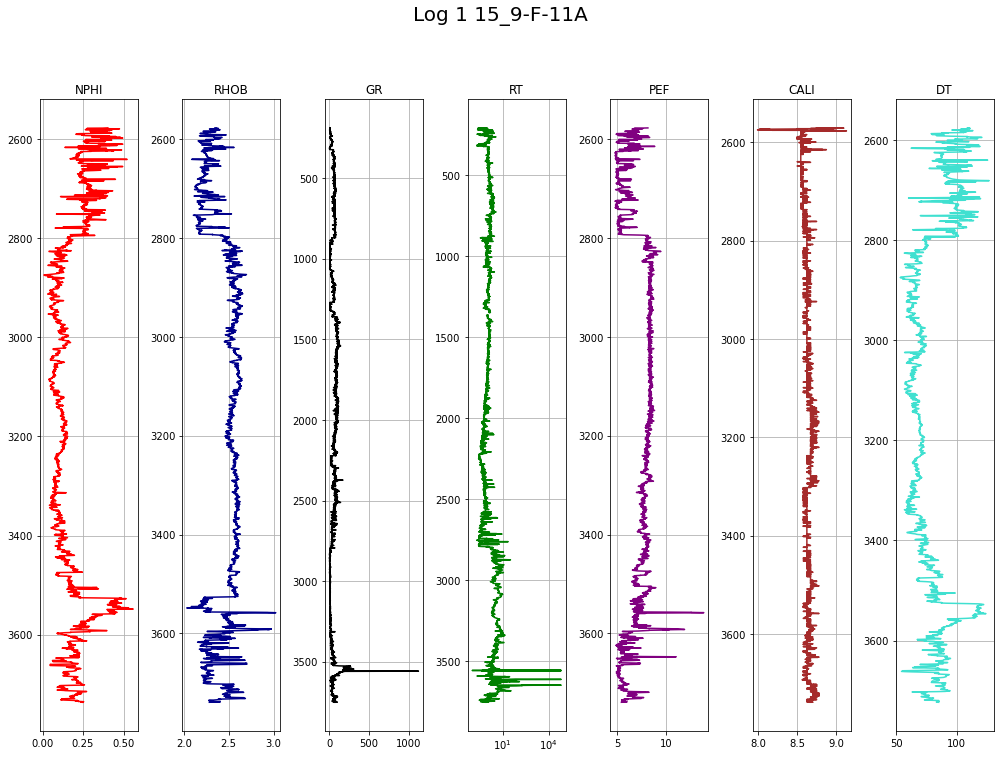

In [6]:
makeplot(log1,"Log 1 15_9-F-11A")

Well 2 and 5 do not contain the 'DT' column.

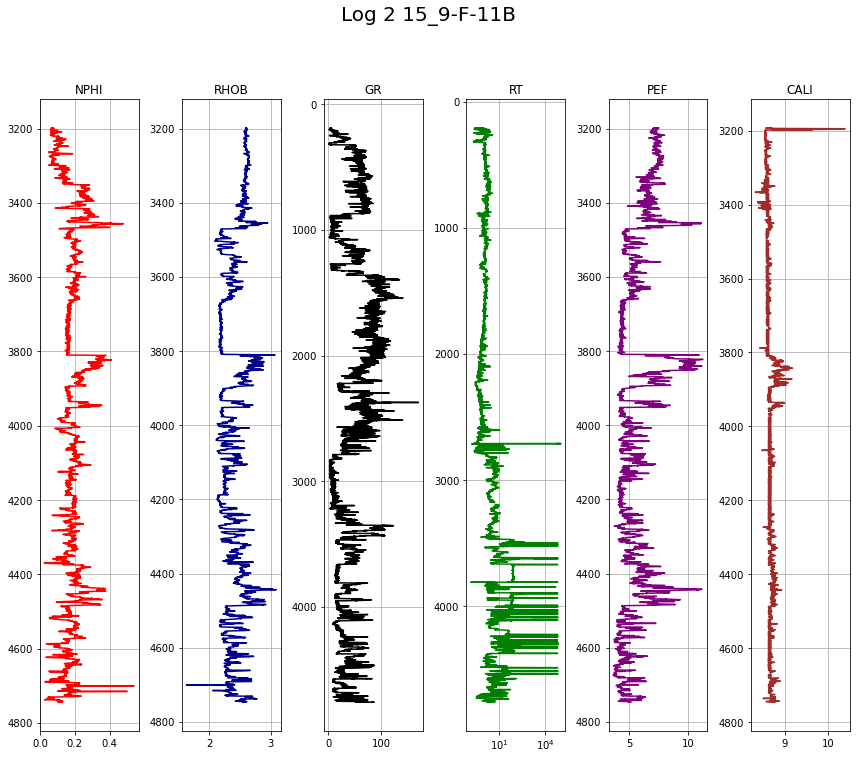

In [7]:
makeplot(log2, "Log 2 15_9-F-11B")

## 2 Data Preparation

1. The train test split is easy, the data is already partitioned by wells:
  - Train on logs 1, 3, and 4.
  - Test (validation) on logs 2 and 5.


2. There are many NAN values in the logs. The plots above only display the samples that are non-NaN and thus can be used to gauge where they need to be clipped. The NaN are primarily present on top and bottom of each log before readings start. The logs get clipped around the following depths:
  - log1 2,600 - 3,720 m
  - log2 3,200 - 4,740 m
  - log3 2,620 - 3,640 m
  - log4 3,100 - 3,400 m
  - log5 3,100 - 4,050 m


3. Furthermore, the logs contain many more featurs than we need. The correct will get selected for further use, the rest gets discarded.

In [8]:
# Check NaN
log1.isna().sum()

DEPTH           0
ABDCQF01    23267
ABDCQF02    23402
ABDCQF03    23839
ABDCQF04    23410
BS              0
CALI        24054
DRHO        24047
DT          24260
DTS         24651
GR            144
NPHI        24138
PEF         24110
RACEHM      23857
RACELM      23857
RD            570
RHOB        24110
RM            570
ROP           386
RPCEHM      23909
RPCELM      23891
RT            570
dtype: int64

In [9]:
# NaN are common near top and bottom of each log
log1

DEPTH  ABDCQF01  ABDCQF02  ABDCQF03  ABDCQF04    BS  CALI  DRHO  DT  \
0       188.5       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN   
1       188.6       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN   
2       188.7       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN   
3       188.8       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN   
4       188.9       NaN       NaN       NaN       NaN  36.0   NaN   NaN NaN   
...       ...       ...       ...       ...       ...   ...   ...   ...  ..   
35730  3761.5       NaN       NaN       NaN       NaN   8.5   NaN   NaN NaN   
35731  3761.6       NaN       NaN       NaN       NaN   8.5   NaN   NaN NaN   
35732  3761.7       NaN       NaN       NaN       NaN   8.5   NaN   NaN NaN   
35733  3761.8       NaN       NaN       NaN       NaN   8.5   NaN   NaN NaN   
35734  3761.9       NaN       NaN       NaN       NaN   8.5   NaN   NaN NaN   

       DTS  ...  PEF  RACEHM  RACELM  RD  RHOB  RM     ROP  RPCEHM  RPCELM  RT  
0      NaN  ...  NaN     NaN     NaN NaN   NaN NaN     NaN     NaN     NaN NaN  
1      NaN  ...  NaN     NaN     NaN NaN   NaN NaN     NaN     NaN     NaN NaN  
2      NaN  ...  NaN     NaN     NaN NaN   NaN NaN     NaN     NaN     NaN NaN  
3      NaN  ...  NaN     NaN     NaN NaN   NaN NaN     NaN     NaN     NaN NaN  
4      NaN  ...  NaN     NaN     NaN NaN   NaN NaN     NaN     NaN     NaN NaN  
...    ...  ...  ...     ...     ...  ..   ...  ..     ...     ...     ...  ..  
35730  NaN  ...  NaN     NaN     NaN NaN   NaN NaN  19.738     NaN     NaN NaN  
35731  NaN  ...  NaN     NaN     NaN NaN   NaN NaN  19.751     NaN     NaN NaN  
35732  NaN  ...  NaN     NaN     NaN NaN   NaN NaN  19.764     NaN     NaN NaN  
35733  NaN  ...  NaN     NaN     NaN NaN   NaN NaN  19.757     NaN     NaN NaN  
35734  NaN  ...  NaN     NaN     NaN NaN   NaN NaN  19.744     NaN     NaN NaN  

[35735 rows x 22 columns]

In [10]:
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):
    
  # clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) & 
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]
  
  # select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

In [11]:
# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# Check for NaN
log1

DEPTH   NPHI   RHOB      GR     RT    PEF   CALI       DT
24115  2600.0  0.371  2.356  82.748  1.323  7.126  8.648  104.605
24116  2600.1  0.341  2.338  79.399  1.196  6.654  8.578  103.827
24117  2600.2  0.308  2.315  74.248  1.171  6.105  8.578  102.740
24118  2600.3  0.283  2.291  68.542  1.142  5.613  8.547  100.943
24119  2600.4  0.272  2.269  60.314  1.107  5.281  8.523   98.473
...       ...    ...    ...     ...    ...    ...    ...      ...
35311  3719.6  0.236  2.617  70.191  1.627  7.438  8.703   84.800
35312  3719.7  0.238  2.595  75.393  1.513  7.258  8.750   85.013
35313  3719.8  0.236  2.571  82.648  1.420  7.076  8.766   85.054
35314  3719.9  0.217  2.544  89.157  1.349  6.956  8.781   84.928
35315  3720.0  0.226  2.520  90.898  1.301  6.920  8.781   84.784

[11201 rows x 8 columns]

Check for NaNs again.

In [12]:
# Sum up the NaN. Result: no NaN in any feature :)
nansum = 0
for i in log_list_clipped:
  nansum += i.isna().sum()
nansum

DEPTH    0.0
NPHI     0.0
RHOB     0.0
GR       0.0
RT       0.0
PEF      0.0
CALI     0.0
DT       NaN
dtype: float64

Next Steps: 

- Concatenate the training logs into a training df and the test logs into a test df

- Assign log/well names to each sample.

- Move column location to the right. 

In [13]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # train data, assign names 
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# train dataframe with logs 1,3,4 vertically stacked
train

NPHI    RHOB       GR      RT     PEF    CALI        DT        WELL  \
24115  0.3710  2.3560  82.7480  1.3230  7.1260  8.6480  104.6050  15_9-F-11A   
24116  0.3410  2.3380  79.3990  1.1960  6.6540  8.5780  103.8270  15_9-F-11A   
24117  0.3080  2.3150  74.2480  1.1710  6.1050  8.5780  102.7400  15_9-F-11A   
24118  0.2830  2.2910  68.5420  1.1420  5.6130  8.5470  100.9430  15_9-F-11A   
24119  0.2720  2.2690  60.3140  1.1070  5.2810  8.5230   98.4730  15_9-F-11A   
...       ...     ...      ...     ...     ...     ...       ...         ...   
32537  0.1861  2.4571  60.4392  1.2337  5.9894  8.7227   75.3947   15_9-F-1B   
32538  0.1840  2.4596  61.8452  1.2452  6.0960  8.6976   75.3404   15_9-F-1B   
32539  0.1798  2.4637  61.1386  1.2960  6.1628  8.6976   75.3298   15_9-F-1B   
32540  0.1780  2.4714  59.3751  1.4060  6.1520  8.6976   75.3541   15_9-F-1B   
32541  0.1760  2.4809  58.3742  1.4529  6.1061  8.6978   75.4476   15_9-F-1B   

        DEPTH  
24115  2600.0  
24116  2600.1  
24117  2600.2  
24118  2600.3  
24119  2600.4  
...       ...  
32537  3399.6  
32538  3399.7  
32539  3399.8  
32540  3399.9  
32541  3400.0  

[24403 rows x 9 columns]

In [14]:
# pred dataframe with logs 2, 5 verically stacked
pred

NPHI    RHOB        GR      RT     PEF    CALI        WELL   DEPTH
30115  0.0750  2.6050    9.3480  8.3310  7.4510  8.5470  15_9-F-11B  3200.0
30116  0.0770  2.6020    9.3620  8.2890  7.4640  8.5470  15_9-F-11B  3200.1
30117  0.0780  2.5990    9.5450  8.2470  7.4050  8.5470  15_9-F-11B  3200.2
30118  0.0790  2.5940   11.1530  8.2060  7.2920  8.5470  15_9-F-11B  3200.3
30119  0.0780  2.5890   12.5920  8.1650  7.1670  8.5470  15_9-F-11B  3200.4
...       ...     ...       ...     ...     ...     ...         ...     ...
39037  0.3107  2.4184  106.7613  2.6950  6.2332  8.5569   15_9-F-1C  4049.6
39038  0.2997  2.4186  109.0336  2.6197  6.2539  8.5569   15_9-F-1C  4049.7
39039  0.2930  2.4232  106.0935  2.5948  6.2883  8.5570   15_9-F-1C  4049.8
39040  0.2892  2.4285  105.4931  2.6344  6.3400  8.6056   15_9-F-1C  4049.9
39041  0.2956  2.4309  109.8965  2.6459  6.3998  8.5569   15_9-F-1C  4050.0

[24902 rows x 8 columns]

## 3 Exploratory Data Analysis

### Pair-plot of the train set

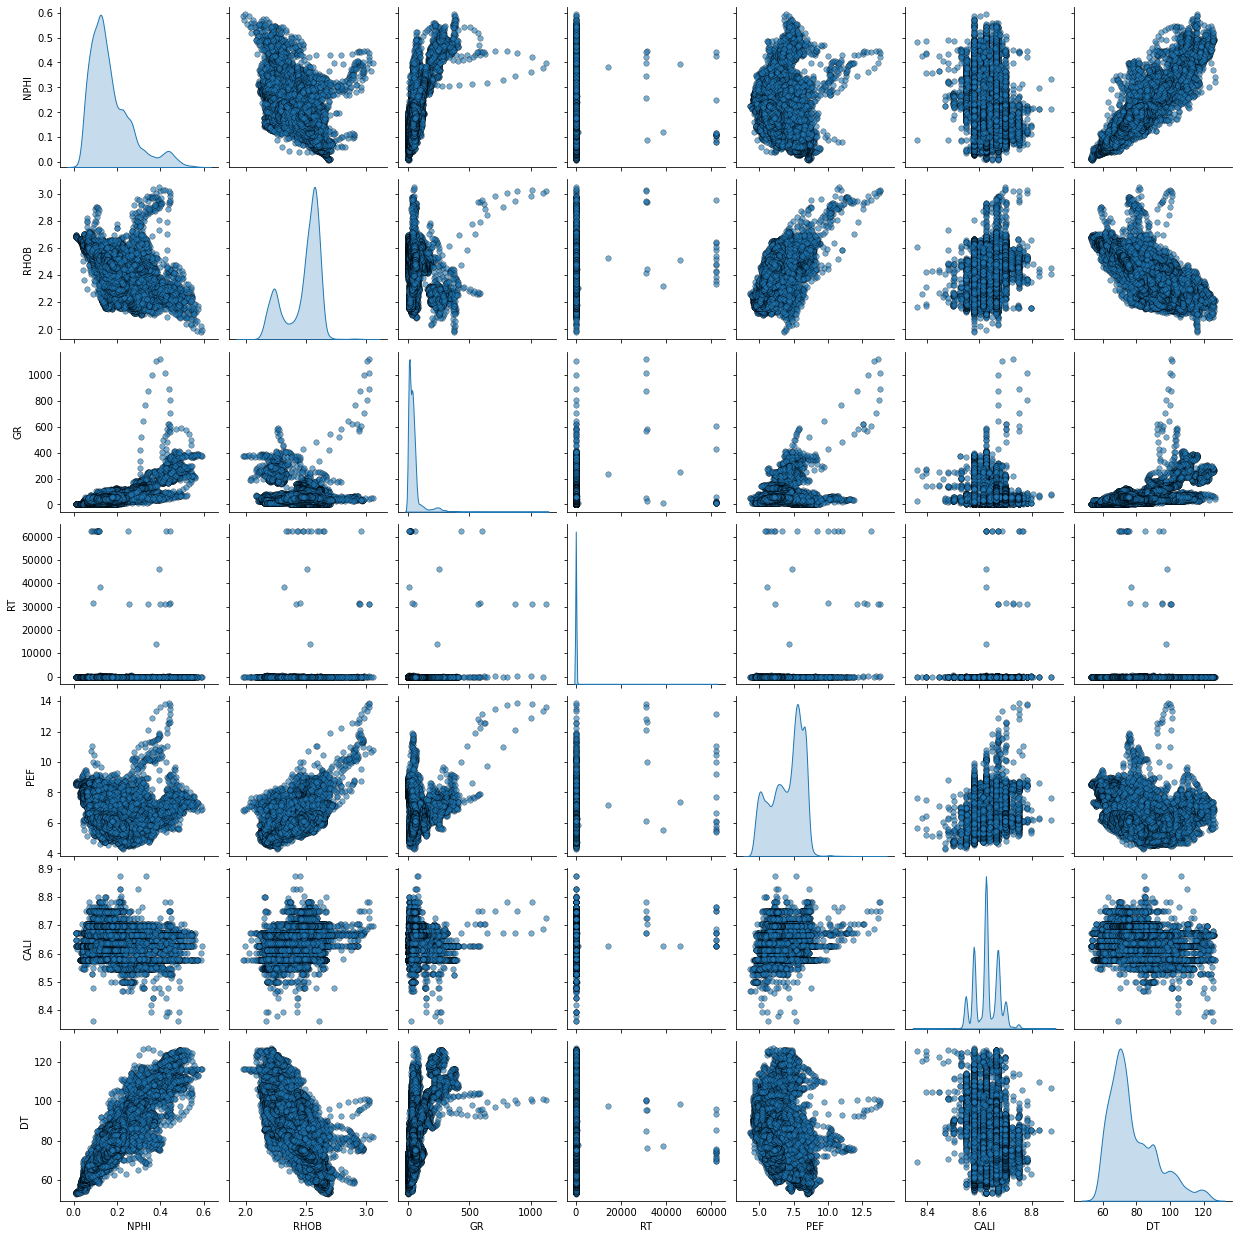

In [15]:
train_features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

sns.pairplot(train, vars=train_features, diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

### Spearman's Correlation Heatmap

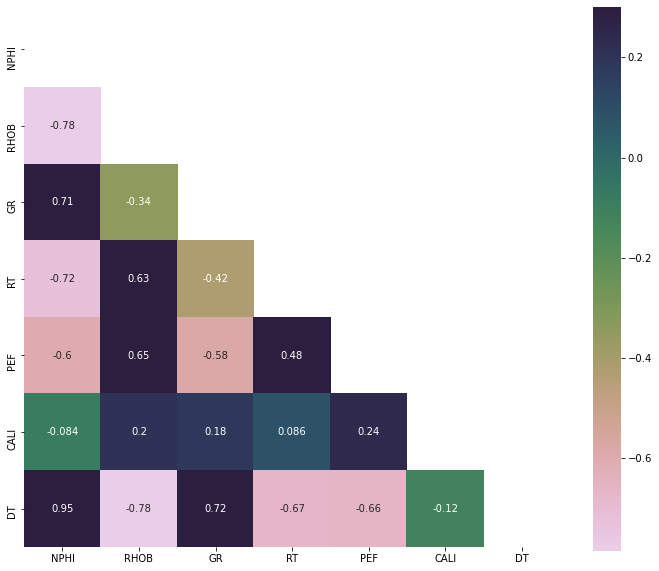

In [16]:
train_only_features = train[train_features]

# Generate a mask for the upper triangle
mask = np.zeros_like(train_only_features.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# custom colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,10))
sns.heatmap(train_only_features.corr(method = 'spearman'), annot=True,  mask=mask, cmap=cmap, vmax=.3, square=True)

plt.show()

## 4 Transformation

Normalize the dataset:
* Log transform the RT log
* Use power transform with Yeo-Johnson method (except 'WELL' and 'DEPTH')

In [17]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
target_name = 'DT' # only target column name
colnames = train.columns
feature_target = np.append(feature_names, target_name) # combined feature and target column names

feature_target

array(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'], dtype='<U4')

In [18]:
colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

In [19]:
# log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans

NPHI      RHOB        GR        RT       PEF      CALI        DT  \
0      1.702168 -0.920748   1.13065 -0.631876  0.031083  0.450019   1.58838   
1      1.573404 -1.020621  1.092435 -0.736154 -0.373325 -1.070848  1.562349   
2      1.407108 -1.142493  1.030314  -0.75808  -0.81989 -1.070848  1.525055   
3      1.260691 -1.263078  0.956135 -0.784153 -1.197992 -1.753641  1.460934   
4      1.189869 -1.367969  0.837247 -0.816586 -1.441155 -2.286221  1.367432   
...         ...       ...       ...       ...       ...       ...       ...   
24398  0.462363 -0.279351  0.839177 -0.704005 -0.910619  2.041708  0.047941   
24399  0.439808 -0.261621  0.860577 -0.694407 -0.826995  1.510434  0.043466   
24400  0.393869 -0.232335  0.849885  -0.65312 -0.774093  1.510434  0.042591   
24401  0.373838 -0.176628   0.82264 -0.569367 -0.782672  1.510434  0.044596   
24402  0.351335 -0.106609  0.806807 -0.535769 -0.819021  1.514682  0.052292   

             WELL   DEPTH  
0      15_9-F-11A  2600.0  
1      15_9-F-11A  2600.1  
2      15_9-F-11A  2600.2  
3      15_9-F-11A  2600.3  
4      15_9-F-11A  2600.4  
...           ...     ...  
24398   15_9-F-1B  3399.6  
24399   15_9-F-1B  3399.7  
24400   15_9-F-1B  3399.8  
24401   15_9-F-1B  3399.9  
24402   15_9-F-1B  3400.0  

[24403 rows x 9 columns]

In [21]:
train_trans.dtypes

NPHI     object
RHOB     object
GR       object
RT       object
PEF      object
CALI     object
DT       object
WELL     object
DEPTH    object
dtype: object

A the column data types are 'object'. Set all the data types correct.

In [22]:
temp1 = train_trans[feature_target].astype(float)
temp2 = train_trans['WELL'].astype(str)
temp3 = train_trans['DEPTH'].astype(float)

train_trans = pd.concat([temp1, temp2, temp3], axis=1)

### Pair-Plot (after transformation)

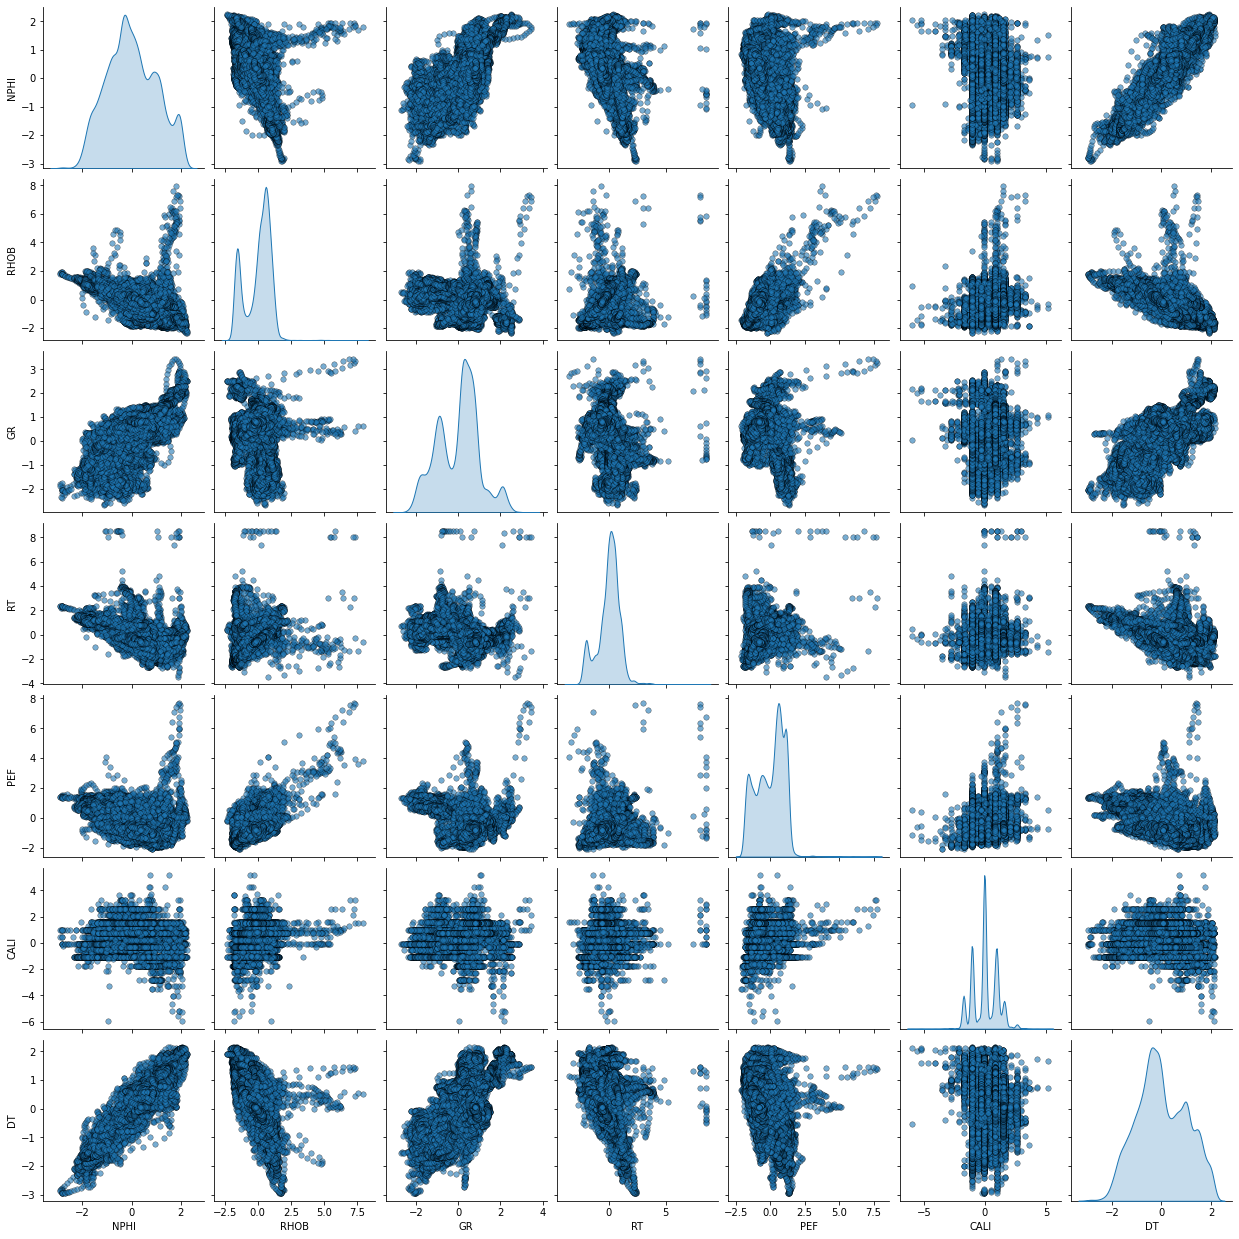

In [23]:
sns.pairplot(train_trans, vars=feature_target, diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

## 5 Removing Outliers

In [24]:
# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)

train_fonly.head()

NPHI      RHOB        GR        RT       PEF      CALI        DT
0  1.702168 -0.920748  1.130650 -0.631876  0.031083  0.450019  1.588380
1  1.573404 -1.020621  1.092435 -0.736154 -0.373325 -1.070848  1.562349
2  1.407108 -1.142493  1.030314 -0.758080 -0.819890 -1.070848  1.525055
3  1.260691 -1.263078  0.956135 -0.784153 -1.197992 -1.753641  1.460934
4  1.189869 -1.367969  0.837247 -0.816586 -1.441155 -2.286221  1.367432

In [25]:
train_fonly_names = train_fonly.columns
train_fonly_names

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'], dtype='object')

In [31]:
# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

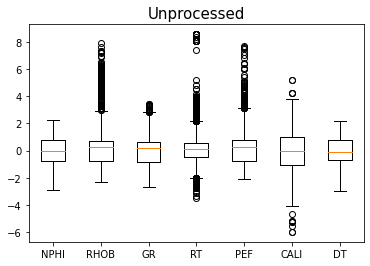

n samples unprocessed: 24403


In [32]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

### Method 1: Standard Deviation

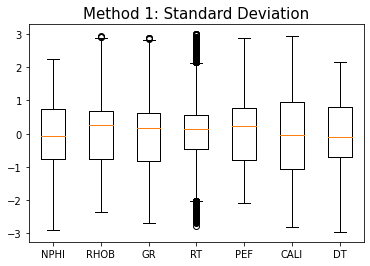

Remaining samples: 24101


In [33]:
train_stdev = train_fonly[np.abs(train_fonly - train_fonly.mean()) <= (3 * train_fonly.std())]

# Delete NaN
train_stdev = train_stdev.dropna()

makeboxplot('Method 1: Standard Deviation',train_stdev)
print('Remaining samples:', len(train_stdev))

### Method 2: Isolation Forest

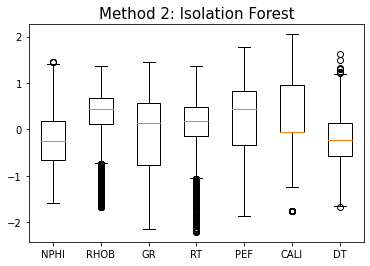

Remaining Samples: 12202


In [34]:
iso = IsolationForest(contamination=0.5)
yhat = iso.fit_predict(train_fonly)
mask = yhat != -1
train_iso = train_fonly[mask]

makeboxplot('Method 2: Isolation Forest',train_iso)
print('Remaining Samples:', len(train_iso))

### Method 3: Minimum Covariance Determinant

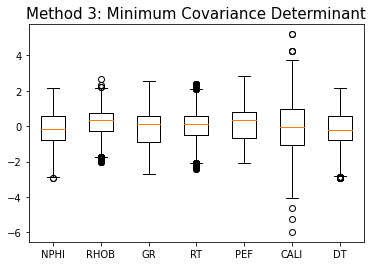

Remaining samples: 21962


In [35]:
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(train_fonly)
mask = yhat != -1
train_ee = train_fonly[mask]

makeboxplot('Method 3: Minimum Covariance Determinant',train_ee)
print('Remaining samples:', len(train_ee))

### Method 4: Local Outlier Factor

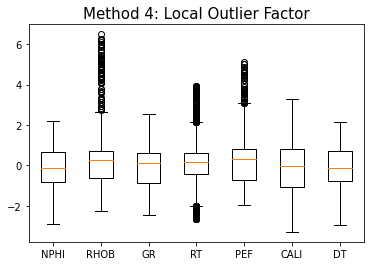

Remaining samples: 17082


In [36]:
lof = LocalOutlierFactor(contamination=0.3)
yhat = lof.fit_predict(train_fonly)
mask = yhat != -1
train_lof = train_fonly[mask]

makeboxplot('Method 4: Local Outlier Factor',train_lof)
print('Remaining samples:', len(train_lof))

### Method 5: Support Vector Machine

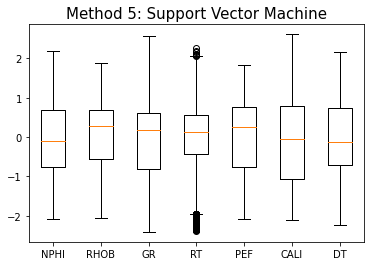

Remaining samples: 21964


In [37]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Method 5: Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

**One-class SVM performs best.**

### Pair-Plot after Removal
Make pair-plot of data after outliers removed. 

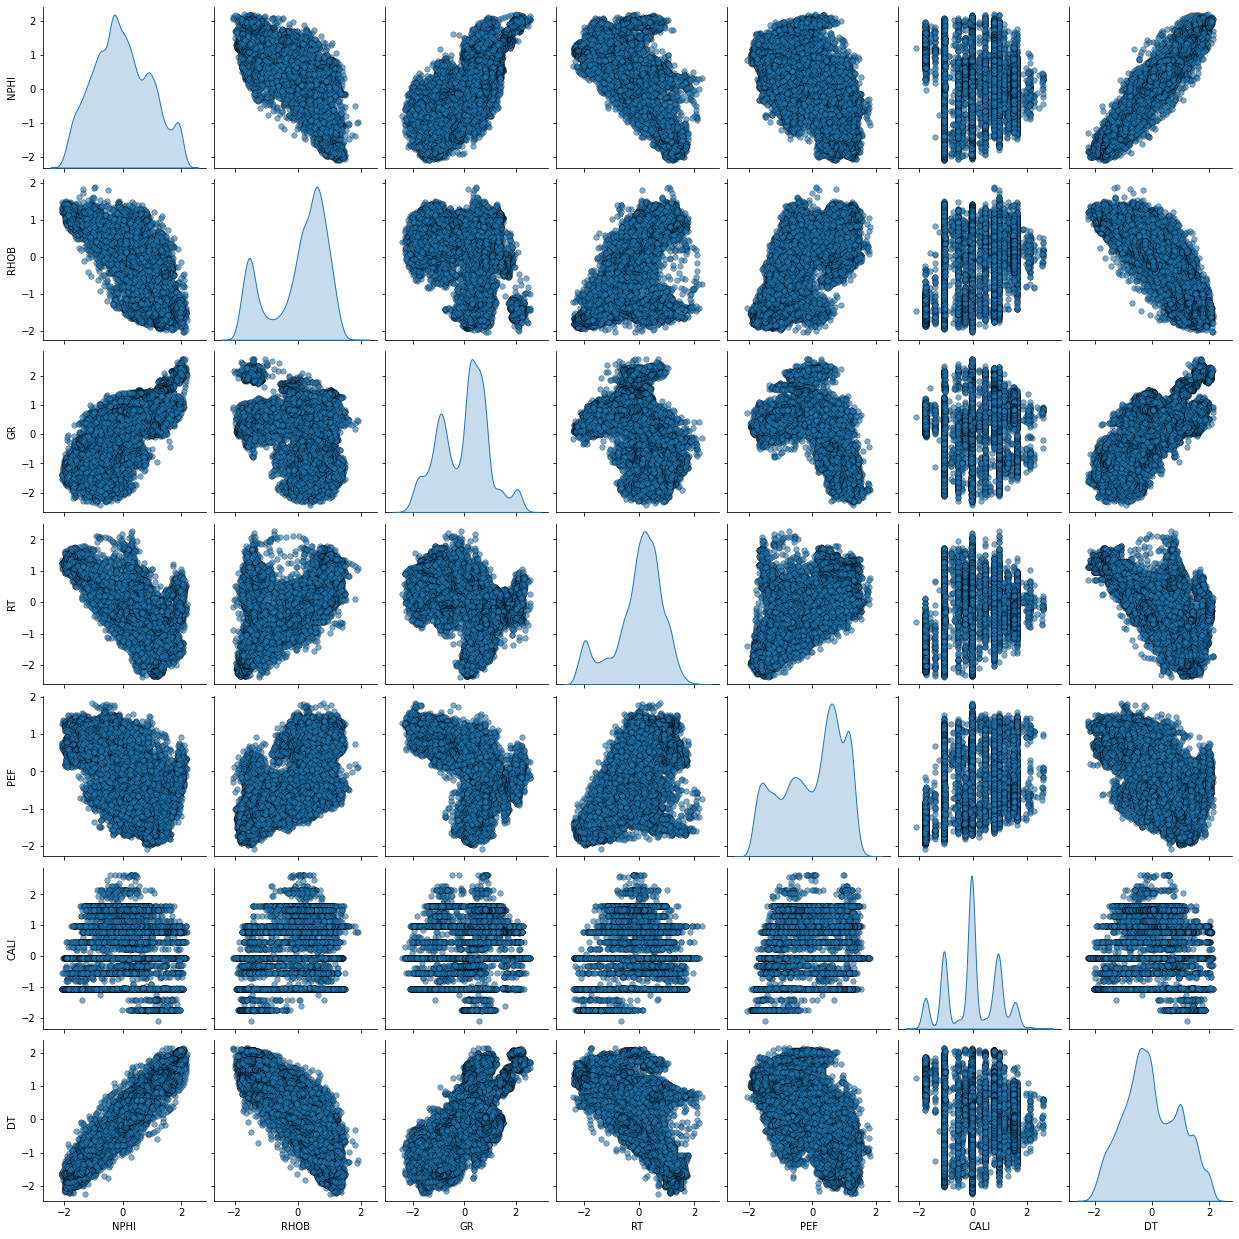

In [38]:
sns.pairplot(train_svm, vars=feature_target,
             diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

## 6 Train and Validate

Define the train data as the SVM outlier-removed-data 

In [39]:
# select columns for features (X) and target (y)
X_train = train_svm[feature_names].values
y_train = train_svm[target_name].values

### Define the validation data
as copy of transformed data (before outlier-removed)

In [40]:
# Define the validation data 
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
  # Split the df by log name
  val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]]

  # Drop name column 
  val = val.drop(['WELL'], axis=1)

  # Define X_val (feature) and y_val (target)
  X_val_, y_val_ = val[feature_names].values, val[target_name].values
  
  X_val.append(X_val_)
  y_val.append(y_val_)

# save into separate dfs
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

### Fit regression and score on validation data

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [43]:
# Gradient Booster object
model = GradientBoostingRegressor()

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Validation: Predict on well 1
y_pred1 = model.predict(X_val1)
print("R2 Log 1: {}".format(round(model.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3 = model.predict(X_val3)
print("R2 Log 3: {}".format(round(model.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4 = model.predict(X_val4)
print("R2 Log 4: {}".format(round(model.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4))
print("RMSE Log 4: {}".format(round(rmse,4)))

R2 Log 1: 0.9526
RMSE Log 1: 0.2338
R2 Log 3: 0.9429
RMSE Log 3: 0.2211
R2 Log 4: 0.8959
RMSE Log 4: 0.2459


### Inverse Transform

In [44]:
# make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# inverse transform  y_val, y_pred
y_val1, y_pred1 = scaler.inverse_transform(y_val1.reshape(-1,1)), scaler.inverse_transform(y_pred1.reshape(-1,1))
y_val3, y_pred3 = scaler.inverse_transform(y_val3.reshape(-1,1)), scaler.inverse_transform(y_pred3.reshape(-1,1))
y_val4, y_pred4 = scaler.inverse_transform(y_val4.reshape(-1,1)), scaler.inverse_transform(y_pred4.reshape(-1,1))

Compare the predicted 'DT' Sonic Log with the true 'DT' Sonic Log

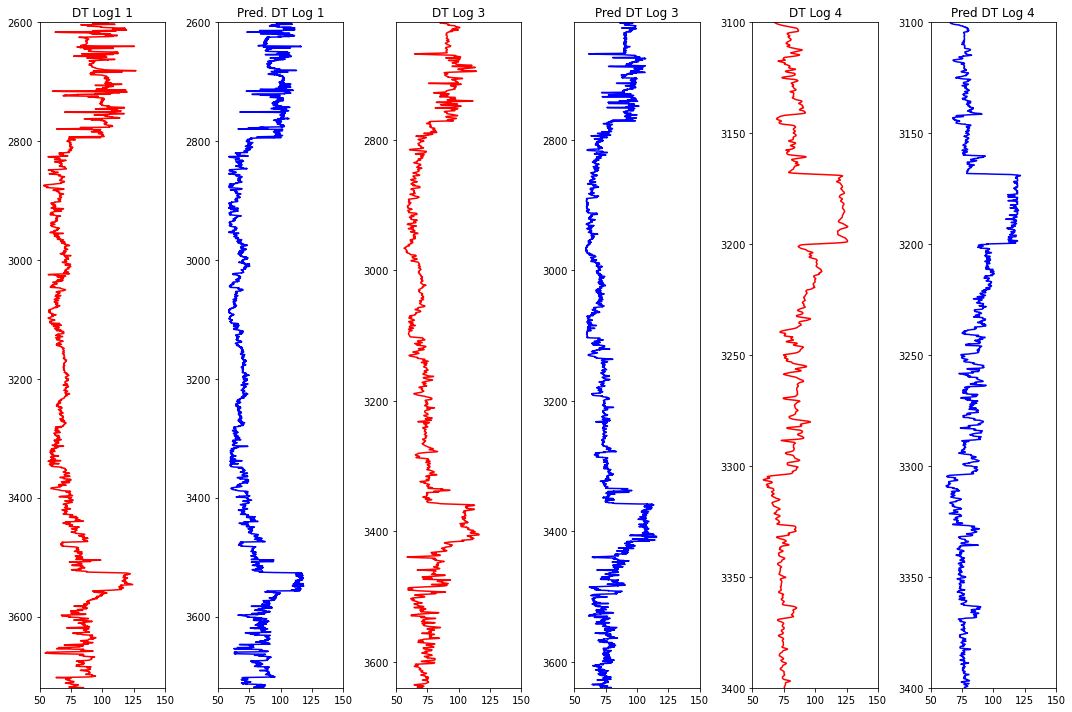

In [45]:
x = [y_val1, y_pred1, y_val3, y_pred3, y_val4, y_pred4]
y = [log1['DEPTH'], log1['DEPTH'], log3['DEPTH'], log3['DEPTH'], log4['DEPTH'], log4['DEPTH']]

color = ['red', 'blue', 'red', 'blue', 'red', 'blue']
title = ['DT Log1 1', 'Pred. DT Log 1', 'DT Log 3', 'Pred DT Log 3',
         'DT Log 4', 'Pred DT Log 4']

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,10))

for i in range(len(x)):
  ax[i].plot(x[i], y[i], color=color[i])
  ax[i].set_xlim(50, 150)
  ax[i].set_ylim(np.max(y[i]), np.min(y[i]))
  ax[i].set_title(title[i])

plt.tight_layout()

plt.show()

## 7 Hyperparameter Tuning

This example below is `GridSearchCV` hyperparameter tuning on Scikit-Learn's `GradientBoostingRegressor`, resulting in 31 models playing through all variations.

Different ways of searching hyperparameters are possible with automated approaches of narrowing it down in a smarter way.

In [46]:
from sklearn.model_selection import train_test_split

# Define the X and y from the SVM normalized dataset
X = train_svm[feature_names].values
y = train_svm[target_name].values

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor()

# Hyperparameter ranges

max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
max_depth = [10, 100]
n_estimators = [100, 1000]

param_grid = {'max_features': max_features,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'max_depth': max_depth,
              'n_estimators': n_estimators}

# Train with grid
model_random = GridSearchCV(model, param_grid, cv=3)
model_random.fit(X_train, y_train)

# Print best model
model_random.best_params_

{'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [48]:
model_random.best_estimator_

GradientBoostingRegressor(max_depth=100, max_features='sqrt',
                          min_samples_leaf=4, n_estimators=1000)

In [49]:
results_df = pd.DataFrame(model_random.cv_results_)
results_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        3.853638      0.068746         0.030936        0.000232   
1       41.054104      0.455140         0.168656        0.004190   
2        3.792058      0.082479         0.025359        0.003786   
3       42.004228      0.435848         0.173092        0.027878   
4        3.906186      0.077078         0.026052        0.007396   
5       41.614311      0.686478         0.161414        0.006962   
6        3.937107      0.116788         0.021990        0.004908   
7       39.786102      0.063213         0.159049        0.004099   
8        1.383478      0.036940         0.030552        0.000186   
9       14.354926      0.059896         0.217801        0.004700   
10       1.388873      0.012859         0.028135        0.003846   
11      14.247409      0.114545         0.197628        0.004165   
12       1.363807      0.015391         0.027380        0.004680   
13      14.546707      0.198646         0.207756        0.012091   
14       1.387118      0.020833         0.030803        0.000110   
15      14.224416      0.052015         0.201266        0.023221   
16       5.937628      0.071827         0.105893        0.004848   
17      58.650220      1.223193         0.965043        0.022554   
18       7.764624      0.230416         0.094077        0.004437   
19     242.105860     25.906416         1.426467        0.056887   
20       8.754867      0.477568         0.095146        0.003626   
21     213.558856     26.276980         1.502565        0.130656   
22       8.653063      0.123132         0.088139        0.003081   
23     204.507642     17.981659         1.478384        0.085989   
24       2.489471      0.026989         0.098044        0.003988   
25      24.239790      1.225127         0.910963        0.024058   
26       2.478428      0.028839         0.085838        0.005435   
27      72.096941      1.687415         1.436087        0.036811   
28       2.971171      0.016785         0.081934        0.000359   
29      61.325213      1.800260         1.309691        0.036375   
30       3.218906      0.132827         0.091025        0.007978   
31      56.945885      5.161788         1.218332        0.064423   

   param_max_depth param_max_features param_min_samples_leaf  \
0               10               auto                      1   
1               10               auto                      1   
2               10               auto                      1   
3               10               auto                      1   
4               10               auto                      4   
5               10               auto                      4   
6               10               auto                      4   
7               10               auto                      4   
8               10               sqrt                      1   
9               10               sqrt                      1   
10              10               sqrt                      1   
11              10               sqrt                      1   
12              10               sqrt                      4   
13              10               sqrt                      4   
14              10               sqrt                      4   
15              10               sqrt                      4   
16             100               auto                      1   
17             100               auto                      1   
18             100               auto                      1   
19             100               auto                      1   
20             100               auto                      4   
21             100               auto                      4   
22             100               auto                      4   
23             100               auto                      4   
24             100               sqrt                      1   
25             100               sqrt                      1   
26             100             

## 8 Predict Test Wells

In [50]:
# Define X_train and y_train
X_train = train[feature_names].values

y_train = train[target_name].values

### Define the Test Data 

In [51]:
# Define the test data 
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature)
  X_test_ = test[feature_names].values

  # define depth
  depth_ = test['DEPTH'].values
  
  X_test.append(X_test_)
  depths.append(depth_)

# for each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

### Transform Test - Predict - Inverse Transform

In [52]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

# Predict to log 2 and 5 with tuned model
y_pred2 = model_random.predict(X_test2)
y_pred5 = model_random.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# inverse transform y_pred
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1,1))
y_pred5 = scaler.inverse_transform(y_pred5.reshape(-1,1))

### Plot the Predictions

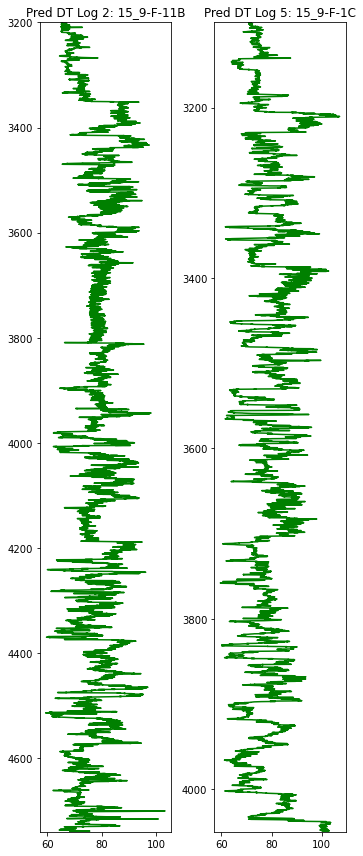

In [53]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(y_pred2, depth2, color='green')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)

plt.subplot(1,2,2)
plt.plot(y_pred5, depth5, color='green')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)

plt.tight_layout()
plt.show()

Write the predicted DT into the original dataframe, then write dataframes to CSV file. 

In [54]:
log2['DT'] = y_pred2
log5['DT'] = y_pred5
log2

C:\Users\ChristianV700\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


DEPTH   NPHI   RHOB      GR     RT    PEF   CALI         DT
30115  3200.0  0.075  2.605   9.348  8.331  7.451  8.547  65.182045
30116  3200.1  0.077  2.602   9.362  8.289  7.464  8.547  65.156720
30117  3200.2  0.078  2.599   9.545  8.247  7.405  8.547  65.173802
30118  3200.3  0.079  2.594  11.153  8.206  7.292  8.547  65.295300
30119  3200.4  0.078  2.589  12.592  8.165  7.167  8.547  65.392683
...       ...    ...    ...     ...    ...    ...    ...        ...
45511  4739.6  0.104  2.587  34.653  4.532  4.472  8.703  70.103718
45512  4739.7  0.104  2.594  33.640  4.356  4.634  8.703  69.672377
45513  4739.8  0.103  2.592  32.217  4.232  4.729  8.734  69.862498
45514  4739.9  0.108  2.583  29.841  4.233  4.705  8.750  69.735983
45515  4740.0  0.114  2.571  31.423  4.225  4.617  8.760  70.268877

[15401 rows x 8 columns]

In [55]:
log5

DEPTH    NPHI    RHOB        GR      RT     PEF    CALI          DT
29541  3100.0  0.1378  2.5729   33.1264  3.0503  7.9837  8.5243   71.758790
29542  3100.1  0.1368  2.5696   32.5644  3.0585  7.9401  8.5243   71.097119
29543  3100.2  0.1351  2.5670   32.3169  3.0454  7.9126  8.5243   70.783521
29544  3100.3  0.1341  2.5668   32.9734  3.0365  7.9216  8.5243   70.962914
29545  3100.4  0.1349  2.5690   33.0557  3.0844  7.9582  8.5243   71.007710
...       ...     ...     ...       ...     ...     ...     ...         ...
39037  4049.6  0.3107  2.4184  106.7613  2.6950  6.2332  8.5569  102.182843
39038  4049.7  0.2997  2.4186  109.0336  2.6197  6.2539  8.5569  101.834436
39039  4049.8  0.2930  2.4232  106.0935  2.5948  6.2883  8.5570  100.780256
39040  4049.9  0.2892  2.4285  105.4931  2.6344  6.3400  8.6056  101.083634
39041  4050.0  0.2956  2.4309  109.8965  2.6459  6.3998  8.5569  100.171822

[9501 rows x 8 columns]

In [56]:
def makeplotpred(df,suptitle_str="pass a suptitle"):
  # column selection from df
  col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
  # plotting titles
  title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT']
  # plotting colors
  colors = ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green']

  # create the subplots; ncols equals the number of logs
  fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(15,10))
  fig.suptitle(suptitle_str, size=20, y=1.05)

  # looping each log to display in the subplots
  for i in range(len(col_names)):
    if i == 3:
      # for resistivity, semilog plot
      ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=colors[i])
    else:
      # for non-resistivity, normal plot
      ax[i].plot(df[col_names[i]], df['DEPTH'], color=colors[i])
  
    ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
    ax[i].set_title(title[i], pad=15)
    ax[i].grid(True)

  ax[2].set_xlim(0, 200)
  plt.tight_layout(1)
  plt.show()

C:\Users\ChristianV700\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


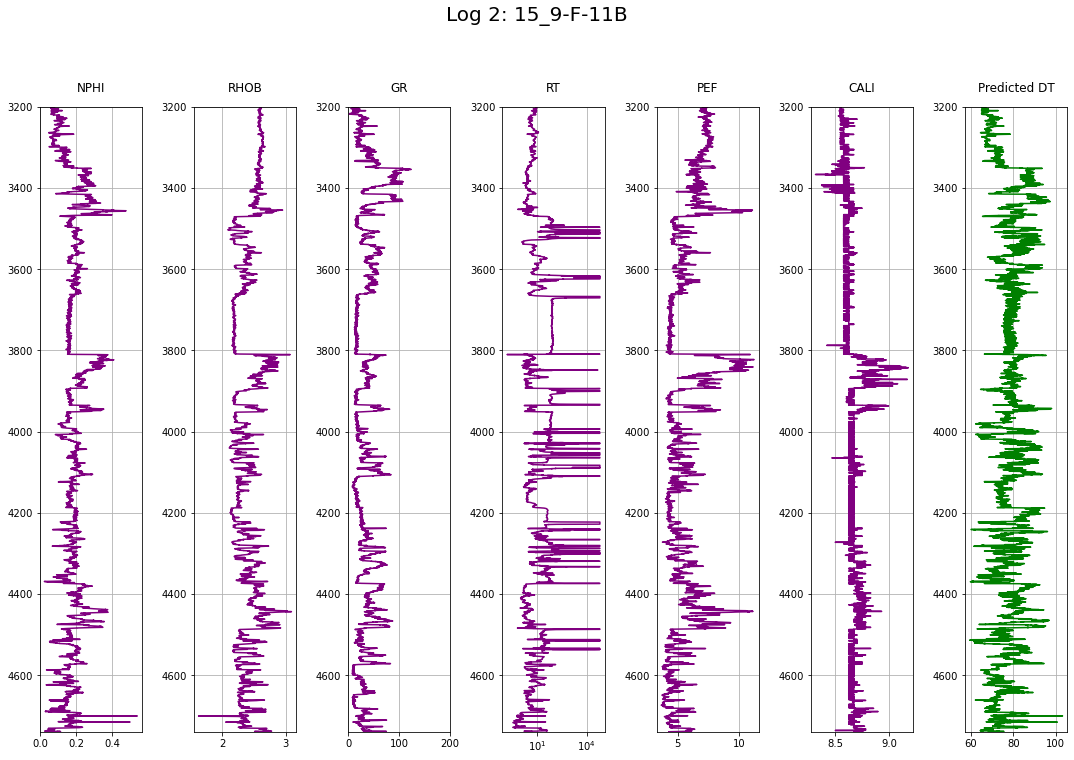

In [57]:
makeplotpred(log2,"Log 2: 15_9-F-11B")

C:\Users\ChristianV700\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


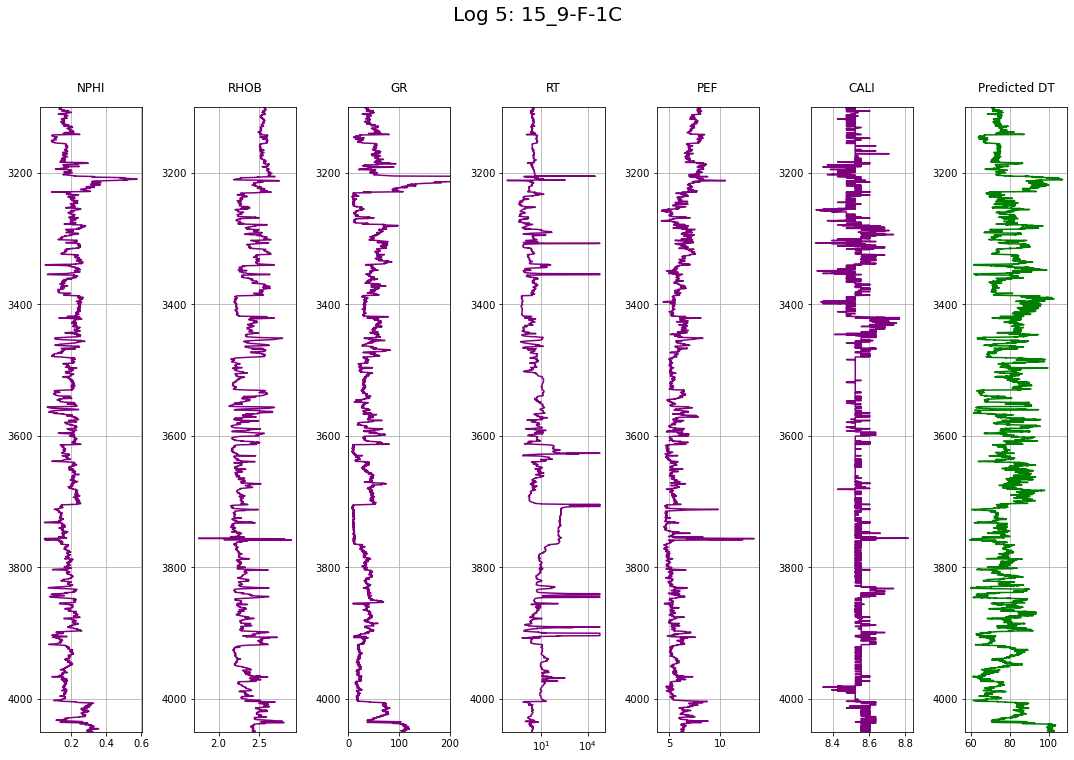

In [58]:
makeplotpred(log5,"Log 5: 15_9-F-1C")

### Save to CSV

In [59]:
log2.to_csv(os.path.join(os.getcwd(),r'results\\log2_15_9-F-11B_Predicted_DT.csv'), index=False)
log5.to_csv(os.path.join(os.getcwd(),r'results\\log5_15_9-F-1C_Predicted_DT.csv'), index=False)